In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt
bempp.core.opencl_kernels.set_default_device(0,0)

In [2]:
deg = 5

In [3]:
def normalized_spherical_harmonics(p, q, x):
    """Spherical Harmonic function of degree q"""
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/np.linalg.norm(x))
    if p >= 0:
        return ((-1)**p) * scipy.special.sph_harm(p,q,azimuth,polar)
    else:
        return scipy.special.sph_harm(-p,q,azimuth,polar)*np.exp(1j*2*p*azimuth)

def spherical_bessel_function(q,x):
    """Spherical Bessel function of degree q"""
    r = np.linalg.norm(x)
    return np.sqrt(np.pi/(2*wavenumber*r))*scipy.special.jv(q+0.5, wavenumber*r)

def regular_spherical_wavefunctions(p,q,x):
    """Regular Spherical Wavefunction"""
    return spherical_bessel_function(q,x)*normalized_spherical_harmonics(p,q,x)

In [1]:
h = 0.1
cube1 = bempp.api.shapes.sphere(r = 1, h=h, origin=(1.5, 0, 0))
cube2 = bempp.api.shapes.sphere(r = 1, h=h, origin=(-1.5, 0, 0))
combined_scatters = bempp.api.grid.grid.union([cube1,cube2])

unit_sphere = bempp.api.shapes.sphere(r = 1, origin=(0,0,0), h = h)
vert_unit_sphere = unit_sphere.vertices
space_unit_sphere = bempp.api.function_space(unit_sphere, 'P', 1)

space_cube1 = bempp.api.function_space(cube1, "P", 1)
space_cube2 = bempp.api.function_space(cube2, "P", 1)
space_combined = bempp.api.function_space(combined_scatters,'P',1)

NameError: name 'bempp' is not defined

In [24]:
wavenumber = 0.8
slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube1, space_cube1, space_cube1, wavenumber)
slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube2 , space_cube1, space_cube1, wavenumber)
slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube1, space_cube2 , space_cube2 , wavenumber)
slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube2 , space_cube2 , space_cube2 , wavenumber)

mat11 = slp11.weak_form().A
mat12 = slp12.weak_form().A
mat21 = slp21.weak_form().A
mat22 = slp22.weak_form().A
mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

mat = np.block([[mat11,mat12],[mat21,mat22]])  
mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])
print(-np.imag(np.log(np.linalg.det(mat @ np.linalg.inv(mat2))))/np.pi)

0.03607936773418221


In [5]:
sph_harm_coeff = []

for q in range(deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def sph_harm(x,n,domain_index,result):
            with objmode():
                result[0] = normalized_spherical_harmonics(p,q,x)
        sph_harm_grid = bempp.api.GridFunction(space_unit_sphere, fun = sph_harm)
        sph_harm_coeff.append(np.conj(sph_harm_grid.coefficients)/((-1j)**(q+1)))

mass_mat = bempp.api.operators.boundary.sparse.identity(space_unit_sphere, space_unit_sphere, space_unit_sphere).weak_form().A

In [25]:
wavenumber = 0.8
eta = wavenumber

identity1 = bempp.api.operators.boundary.sparse.identity(space_cube1, space_cube1, space_cube1)
slp1 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube1, space_cube1, space_cube1, wavenumber)
dlp1 = bempp.api.operators.boundary.helmholtz.double_layer(space_cube1, space_cube1, space_cube1, wavenumber)
slp_far1 = helmholtz_farfield.single_layer(space_cube1, vert_unit_sphere, wavenumber)
dlp_far1 = helmholtz_farfield.double_layer(space_cube1, vert_unit_sphere, wavenumber)

lhs1 = 0.5 * identity1 + dlp1 - 1j* eta *slp1

identity2 = bempp.api.operators.boundary.sparse.identity(space_cube2, space_cube2, space_cube2)
slp2 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube2, space_cube2, space_cube2, wavenumber)
dlp2 = bempp.api.operators.boundary.helmholtz.double_layer(space_cube2, space_cube2, space_cube2, wavenumber)
slp_far2 = helmholtz_farfield.single_layer(space_cube2, vert_unit_sphere, wavenumber)
dlp_far2 = helmholtz_farfield.double_layer(space_cube2, vert_unit_sphere, wavenumber)

lhs2 = 0.5 * identity2 + dlp2 - 1j* eta *slp2

identity = bempp.api.operators.boundary.sparse.identity(space_combined, space_combined, space_combined)
slp = bempp.api.operators.boundary.helmholtz.single_layer(space_combined, space_combined, space_combined, wavenumber)
dlp = bempp.api.operators.boundary.helmholtz.double_layer(space_combined, space_combined, space_combined, wavenumber)
slp_far = helmholtz_farfield.single_layer(space_combined, vert_unit_sphere, wavenumber)
dlp_far = helmholtz_farfield.double_layer(space_combined, vert_unit_sphere, wavenumber)

lhs = 0.5 * identity + dlp - 1j* eta *slp

slp_far_field_coeff1 = []
for q in range(deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def dirichlet_fun(x,n,domain_index,result):
                with objmode():
                    result[0] = - regular_spherical_wavefunctions(p,q,x)

        rhs_fun1 = bempp.api.GridFunction(space_cube1, fun = dirichlet_fun)
        field1, info1 = bempp.api.linalg.gmres(lhs1, rhs_fun1, tol=1E-8)
        slp_far_field_coeff1.append(dlp_far1.evaluate(field1) - 1j * eta * slp_far1.evaluate(field1))

slp_far_field_coeff2 = []
for q in range(deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def dirichlet_fun(x,n,domain_index,result):
                with objmode():
                    result[0] = - regular_spherical_wavefunctions(p,q,x)
        rhs_fun2 = bempp.api.GridFunction(space_cube2, fun = dirichlet_fun)
        field2, info2 = bempp.api.linalg.gmres(lhs2, rhs_fun2, tol=1E-8)
        slp_far_field_coeff2.append(dlp_far2.evaluate(field2) - 1j * eta * slp_far2.evaluate(field2))

slp_far_field_coeff = []
for q in range(deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def dirichlet_fun(x,n,domain_index,result):
                with objmode():
                    result[0] = - regular_spherical_wavefunctions(p,q,x)

        rhs_fun = bempp.api.GridFunction(space_combined, fun = dirichlet_fun)
        field, info = bempp.api.linalg.gmres(lhs, rhs_fun, tol=1E-8)
        slp_far_field_coeff.append(dlp_far.evaluate(field) - 1j * eta * slp_far.evaluate(field))

T_matrix1 = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
for i in range((deg+1)**2):
    for j in range((deg+1)**2):
        T_matrix1[i,j] = (slp_far_field_coeff1[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

T_matrix2 = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
for i in range((deg+1)**2):
    for j in range((deg+1)**2):
        T_matrix2[i,j] = (slp_far_field_coeff2[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

T_matrix = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
for i in range((deg+1)**2):
    for j in range((deg+1)**2):
        T_matrix[i,j] = (slp_far_field_coeff[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

S_matrix = np.identity(T_matrix.shape[0]) + 2*T_matrix
S_matrix1 = np.identity(T_matrix1.shape[0]) + 2*T_matrix1
S_matrix2 = np.identity(T_matrix2.shape[0]) + 2*T_matrix2

#rhs_value_S =  (np.log(np.linalg.det(S_matrix))-(np.log(np.linalg.det(S_matrix1)) + np.log(np.linalg.det(S_matrix2))))
rhs_value_S =  np.log(np.linalg.det(S_matrix)/(np.linalg.det(S_matrix1)*np.linalg.det(S_matrix2)))

print(rhs_value_S/(2*1j*np.pi))

ValueError: dimension mismatch

In [31]:
_lst1 = [0, 0.0381544158702414, 0.059897532507547854, 0.07219982064283478, 0.07870874101386678, 0.07967374113803526, 
         0.07600777824281044, 0.06853494223791011,  0.05788082446004275,  0.044743418077426725,  0.030372187925519635,  
         0.017429292560513177]

In [35]:
print(np.trapz(np.array(_lst1), np.arange(0,3,0.25))/2)

0.07686100604956153


In [10]:
lhs_list_005 = [-7.50166246e-06, -4.72811321e-03, -9.34907854e-03, -1.37774507e-02, -1.79325142e-02, -2.17499755e-02, -2.51842836e-02, -2.82090370e-02,
                -3.08157173e-02, -3.30111707e-02, -3.48143333e-02, -3.62526732e-02, -3.73587430e-02, -3.81671235e-02, -3.87119307e-02, -3.90249599e-02,
                -3.91344626e-02, -3.90645019e-02, -3.88347921e-02, -3.84609174e-02]
rhs_list_005 = [-7.23278779e-06, -4.72592458e-03, -9.34472915e-03, -1.37709846e-02, -1.79239906e-02, -2.17394614e-02, -2.51718466e-02, -2.81947384e-02,
                -3.07996076e-02, -3.29932863e-02, -3.47946960e-02, -3.62312913e-02, -3.73356136e-02, -3.81422359e-02, -3.86852703e-02, -3.89965110e-02,
                -3.91042122e-02, -3.90324414e-02, -3.88009189e-02, -3.84252354e-02]

lhs_list_003 = [-7.62784415e-06, -4.80772337e-03, -9.50699240e-03, -1.40114738e-02, -1.82397346e-02, -2.21271389e-02, 
                -2.56281835e-02, -2.87168602e-02, -3.13853025e-02, -3.36411553e-02, -3.55041863e-02, -3.70026265e-02, 
                -3.81696435e-02, -3.90402356e-02, -3.96487162e-02, -4.00268611e-02,
                -4.02027092e-02, -4.01999543e-02, -4.00378297e-02, -3.97313725e-02]
rhs_list_003 = [-7.595144570305771e-06, -0.004806945150507008, -0.009505445701829306, -0.014009174262878718, -0.018236703075727233, -0.022123399256772154,
               -0.02562375932721709, -0.028711773133214248, -0.03137956986020781, -0.03363478975927726, -0.0354971949676079,  -0.03699501152789325,
               -0.03816140307334358, -0.03903136480217048, -0.0396392086161472, -0.04001670996104018,
               -0.040191908493209624, -0.04018849943290711, -0.040025718198453075, -0.03971860435996524]

In [11]:
rel_error_005 = []
for i in range(len(lhs_list_005)):
    rel_error_005.append(abs((lhs_list_005[i] - rhs_list_005[i])/lhs_list_005[i]))
    
rel_error_003 = []
for i in range(len(lhs_list_003)):
    rel_error_003.append(abs((lhs_list_003[i] - rhs_list_003[i])/lhs_list_003[i]))

In [ ]:
rel_error_005

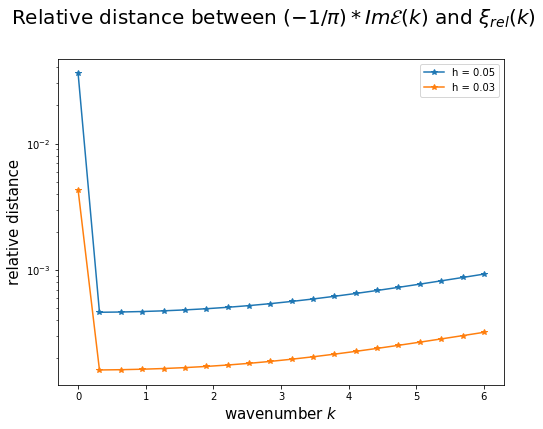

In [32]:
plt.figure(figsize = [8,6])
plt.semilogy(np.linspace(0.0005,6,20), rel_error_005, '*-')
plt.semilogy(np.linspace(0.0005,6,20), rel_error_003, '*-')
plt.legend(['h = 0.05', 'h = 0.03'])
plt.xlabel('wavenumber $k$', fontsize = 15)
plt.ylabel('relative distance', fontsize= 15)
plt.suptitle('Relative distance between $(-1/\pi)*\t{Im}\mathcal{E}(k)$ and $\\xi_{\t{rel}}(k)$', fontsize = 20, y = 1)
plt.savefig('Scalar proof equality.pdf')

In [ ]:
print(lhs_value/(2*np.pi*1j), rhs_value_S/(2*np.pi*1j))

In [ ]:
#r = 0.1 distance is 0.1 h = 0.05
k = 0.0005 (-7.501662460339033e-06+0j) (-7.232787787112242e-06+1.6058324017247197e-06j)
k = 1 (-0.014485280303157835+0j) (-0.014478469617918188+9.766007577302322e-07j)
k = 2 (-0.026235542694017233+0j) (-0.026222480729206254-5.539536383469175e-07j)
k = 3 (-0.03395880298716372+0j) (-0.033940041698481284-2.0343339366399597e-06j)
k = 4 (-0.03792819971072091+0j) (-0.03790390066362344-2.9147302937855247e-06j)
k = 5 (-0.039129258504906644+0j) (-0.03909930956269753-3.2112567740173982e-06j)
k = 6 (-0.03846091738133615+0j) (-0.03842523543499039-3.212752733380268e-06j)

In [ ]:
casimir_energy = np.trapz(-np.array(result_normal2),range(7) ) / (2 * np.pi)
#casimir_energy = np.trapz(-np.array(result_normal1)/quad_points,quad_points ) / (2 * np.pi)

print(casimir_energy)

In [ ]:
result_rhs = [-7.232787787112242e-06, -0.014478469617918188, -0.026222480729206254, -0.033940041698481284, -0.03790390066362344,
             -0.03909930956269753, -0.03842523543499039]

In [ ]:
np.trapz(-np.array(result_rhs), [0.0005, 1, 2, 3, 4, 5, 6])/2

In [ ]:
N_wn = 20
lbound_wn = 0   
ubound_wn = 6    
quad_points = np.linspace(np.exp(-ubound_wn), np.exp(-lbound_wn), N_wn)

In [22]:
wavenumber = -0.8*1j
    
slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube1, space_cube1, space_cube1, wavenumber)
slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube2 , space_cube1, space_cube1, wavenumber)
slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube1, space_cube2 , space_cube2 , wavenumber)
slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube2 , space_cube2 , space_cube2 , wavenumber)

mat11 = slp11.weak_form().A
mat12 = slp12.weak_form().A
mat21 = slp21.weak_form().A
mat22 = slp22.weak_form().A
mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

mat = np.block([[mat11,mat12],[mat21,mat22]])  
mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

print(np.log(np.linalg.det(mat @ np.linalg.inv(mat2))))

nan


/home/xiaoshu/.conda/envs/opencl/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


In [24]:
cas_test = np.trapz(-np.array(_lst), np.arange(0,3,0.25))/(2*np.pi)
#cas_test = np.trapz(-test_result, np.linspace(0,10,20))/(2*np.pi)

print(cas_test)

0.04198358402397187


In [ ]:
plt.plot(np.linspace(0,50,20), -test_result)

In [3]:
points = np.linspace(0,6,20)
points[0] = 0.0005

In [9]:
result_10 = [-7.232787787112242e-06*np.exp(-10*points[0]**2), -0.004718896597437333*np.exp(-10*points[1]**2), 
       -0.009338300759104648*np.exp(-10*points[2]**2), -0.013765248134936193*np.exp(-10*points[3]**2), 
       -0.01791899808609973*np.exp(-10*points[4]**2), -0.021735225937005036*np.exp(-10*points[5]**2),
       -0.025168346396095293*np.exp(-10*points[6]**2), -0.028191924077237175*np.exp(-10*points[7]**2), 
       -0.030797409950651795*np.exp(-10*points[8]**2), -0.032991624746426196*np.exp(-10*points[9]**2), 
       -0.03479348536255959*np.exp(-10*points[10]**2), -0.0362304479449247*np.exp(-10*points[11]**2),
       -0.037335059513346695*np.exp(-10*points[12]**2), -0.03814190123425788*np.exp(-10*points[13]**2), 
       -0.038685094353916205*np.exp(-10*points[14]**2), -0.038996442628638724*np.exp(-10*points[15]**2), 
       -0.039104208648375854*np.exp(-10*points[16]**2), -0.039032467134512756*np.exp(-10*points[17]**2),
      -0.03880094434447416*np.exp(-10*points[18]**2), -0.03842523543499039*np.exp(-10*points[19]**2)]

In [10]:
casimir_energy_10 = np.trapz(-np.array(result_10), points)/2
print(casimir_energy_10)

0.00030279780718243444


In [11]:
result_5 = [-7.232787787112242e-06*np.exp(-5*points[0]**2), -0.004718896597437333*np.exp(-5*points[1]**2), 
       -0.009338300759104648*np.exp(-5*points[2]**2), -0.013765248134936193*np.exp(-5*points[3]**2), 
       -0.01791899808609973*np.exp(-5*points[4]**2), -0.021735225937005036*np.exp(-5*points[5]**2),
       -0.025168346396095293*np.exp(-5*points[6]**2), -0.028191924077237175*np.exp(-5*points[7]**2), 
       -0.030797409950651795*np.exp(-5*points[8]**2), -0.032991624746426196*np.exp(-5*points[9]**2), 
       -0.03479348536255959*np.exp(-5*points[10]**2), -0.0362304479449247*np.exp(-5*points[11]**2),
       -0.037335059513346695*np.exp(-5*points[12]**2), -0.03814190123425788*np.exp(-5*points[13]**2), 
       -0.038685094353916205*np.exp(-5*points[14]**2), -0.038996442628638724*np.exp(-5*points[15]**2), 
       -0.039104208648375854*np.exp(-5*points[16]**2), -0.039032467134512756*np.exp(-5*points[17]**2),
      -0.03880094434447416*np.exp(-5*points[18]**2), -0.03842523543499039*np.exp(-5*points[19]**2)]

In [13]:
casimir_energy_5 = np.trapz(-np.array(result_5), points)/2
print(casimir_energy_5)

0.0006788452202744073


In [14]:
result_005 = [-7.232787787112242e-06*np.exp(-0.05*points[0]**2), -0.004718896597437333*np.exp(-0.05*points[1]**2), 
       -0.009338300759104648*np.exp(-0.05*points[2]**2), -0.013765248134936193*np.exp(-0.05*points[3]**2), 
       -0.01791899808609973*np.exp(-0.05*points[4]**2), -0.021735225937005036*np.exp(-0.05*points[5]**2),
       -0.025168346396095293*np.exp(-0.05*points[6]**2), -0.028191924077237175*np.exp(-0.05*points[7]**2), 
       -0.030797409950651795*np.exp(-0.05*points[8]**2), -0.032991624746426196*np.exp(-0.05*points[9]**2), 
       -0.03479348536255959*np.exp(-0.05*points[10]**2), -0.0362304479449247*np.exp(-0.05*points[11]**2),
       -0.037335059513346695*np.exp(-0.05*points[12]**2), -0.03814190123425788*np.exp(-0.05*points[13]**2), 
       -0.038685094353916205*np.exp(-0.05*points[14]**2), -0.038996442628638724*np.exp(-0.05*points[15]**2), 
       -0.039104208648375854*np.exp(-0.05*points[16]**2), -0.039032467134512756*np.exp(-0.05*points[17]**2),
      -0.03880094434447416*np.exp(-0.05*points[18]**2), -0.03842523543499039*np.exp(-0.05*points[19]**2)]

In [15]:
casimir_energy_005 = np.trapz(-np.array(result_005), points)/2
print(casimir_energy_005)

0.04486558719380678


In [16]:
rhs = [-7.232787787112242e-06, -0.004718896597437333, -0.009338300759104648, -0.013765248134936193, -0.01791899808609973, -0.021735225937005036,
       -0.025168346396095293, -0.028191924077237175, -0.030797409950651795, -0.032991624746426196, -0.03479348536255959, -0.0362304479449247,
       -0.037335059513346695, -0.03814190123425788, -0.038685094353916205, -0.038996442628638724, -0.039104208648375854, -0.039032467134512756,
      -0.03880094434447416, -0.03842523543499039]

In [6]:
casimir_energy_rhs = np.trapz(-np.array(rhs), points)/2
print(casimir_energy_rhs)

0.08604608185788402


In [18]:
for t in range(10):
    list_= []
    for i in range(len(rhs)):
        list_.append(rhs[i]*np.exp(-t*points[i]**2))
    print (np.trapz(-np.array(list_), points)/2)

0.08604608185930927
0.0035605734370226768
0.0017786068495999783
0.0011709319357966123
0.0008641182975583654
0.0006788452202744073
0.0005546549603216253
0.00046545705099559415
0.00039813843842876815
0.00034538449660723213


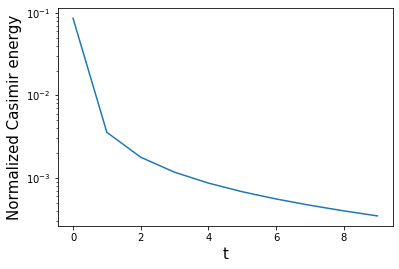

In [23]:
plt.semilogy(range(10), [0.08604608185930927, 0.0035605734370226768, 0.0017786068495999783, 0.0011709319357966123, 0.0008641182975583654, 0.0006788452202744073,
                     0.0005546549603216253, 0.00046545705099559415, 0.00039813843842876815, 0.00034538449660723213])
#0.07521562375582018
plt.xlabel('t', fontsize = 15)
plt.ylabel('Normalized Casimir energy', fontsize = 15)
plt.savefig('converge as t tends to 0.pdf')

In [12]:
list_

array([5.00e-04, 2.50e-01, 5.00e-01, 7.50e-01, 1.00e+00, 1.25e+00,
       1.50e+00, 1.75e+00, 2.00e+00, 2.25e+00, 2.50e+00, 2.75e+00,
       3.00e+00, 3.25e+00, 3.50e+00, 3.75e+00, 4.00e+00, 4.25e+00,
       4.50e+00, 4.75e+00, 5.00e+00, 5.25e+00, 5.50e+00, 5.75e+00])

In [11]:
np.arange(0,6, 0.25)

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
       5.5 , 5.75])